In [ ]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from loguru import logger
from omegaconf import OmegaConf

# import warnings
# warnings.filterwarnings("ignore")

# Useful imports
import os
from pathlib import Path
import tempfile

import hydra

os.environ["NUPLAN_DATA_ROOT"] = "/home/robotic/Downloads/nuplan"
os.environ["NUPLAN_MAPS_ROOT"] = '/home/robotic/Downloads/nuplan/dataset/maps'
os.environ["NUPLAN_DB_FILES"] = '/home/robotic/Downloads/nuplan/nuplan-v1.1/mini'
os.environ["NUPLAN_MAP_VERSION"] = 'nuplan-maps-v1.0'
NUPLAN_DATA_ROOT = os.getenv('NUPLAN_DATA_ROOT', '~/Downloads/nuplan')
NUPLAN_MAPS_ROOT = os.getenv('NUPLAN_MAPS_ROOT', '~/Downloads/nuplan/dataset/maps')
NUPLAN_DB_FILES = os.getenv('NUPLAN_DB_FILES', '~/Downloads/nuplan/nuplan-v1.1/mini')
NUPLAN_MAP_VERSION = os.getenv('NUPLAN_MAP_VERSION', 'nuplan-maps-v1.0')


# Location of path with all training configs
CONFIG_PATH = 'nuplan-devkit/nuplan/planning/script/config/training'
CONFIG_NAME = 'default_training'

# Create a temporary directory to store the cache and experiment artifacts
SAVE_DIR = os.path.join('tmp' ,'tutorial_nuplan_framework')  # optionally replace with persistent dir
os.makedirs(SAVE_DIR, exist_ok=True)
EXPERIMENT = 'training_raster_experiment'
LOG_DIR = os.path.join(SAVE_DIR, EXPERIMENT)
os.makedirs(LOG_DIR, exist_ok=True)

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration 
cfg = hydra.compose(config_name=CONFIG_NAME, overrides=[
    f'group={str(SAVE_DIR)}',
    f'cache.cache_path={str(SAVE_DIR)}/cache',
    f'experiment_name={EXPERIMENT}',
    'py_func=cache',
    '+training=training_raster_model',  # raster model that consumes ego, agents and map raster layers and regresses the ego's trajectory
    'scenario_builder=nuplan_mini',  # use nuplan mini database
    'scenario_filter.limit_total_scenarios=500',  # Choose 500 scenarios to train with
    'lightning.trainer.params.accelerator=ddp_spawn',  # ddp is not allowed in interactive environment, using ddp_spawn instead - this can bottleneck the data pipeline, it is recommended to run training outside the notebook
    'lightning.trainer.params.max_epochs=30',
    'data_loader.params.batch_size=32',
    'data_loader.params.num_workers=8',

    'cache.cleanup_cache=True', 

    'worker=single_machine_thread_pool'
])


# cfg.splitter = 1
# cfg.scenario_builder.scenario_mapping.scenario_map = 1
# logger.info(OmegaConf.to_yaml(cfg))

# from nuplan.planning.script.run_training import main as main_train

# main_train(cfg)


from nuplan.planning.script.builders.utils.utils_config import update_config_for_training
from nuplan.planning.script.builders.folder_builder import build_training_experiment_folder
from nuplan.planning.script.builders.worker_pool_builder import build_worker

update_config_for_training(cfg)
# print(cfg.worker)
# build_training_experiment_folder(cfg)

worker = build_worker(cfg)
# print(worker.number_of_threads)

# from nuplan.planning.training.experiments.training import build_training_engine

# engine = build_training_engine(cfg, worker)
# print(type(engine.datamodule._train_set))


from nuplan.planning.script.builders.model_builder import build_torch_module_wrapper
from nuplan.planning.script.builders.training_builder import build_lightning_datamodule


torch_module_wrapper = build_torch_module_wrapper(cfg.model)
# print(type(torch_module_wrapper))
# feature_builders = torch_module_wrapper.get_list_of_required_feature()
# target_builders = torch_module_wrapper.get_list_of_computed_target()
# print(target_builders)

datamodule = build_lightning_datamodule(cfg, worker, torch_module_wrapper)
datamodule.setup(stage='fit')

train_dataloader = datamodule.train_dataloader()
print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [2]:
data = next(iter(train_dataloader))

In [3]:
import numpy as np 

In [ ]:
print(data[2])

In [11]:
print(data[0]['raster'].data.shape)

torch.Size([32, 4, 224, 224])


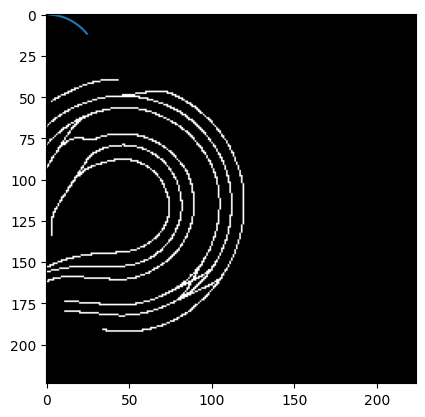

In [169]:
tmp = data[0]['raster'].baseline_paths_layer.numpy()
plt.imshow(tmp[2,:,:], cmap='gray')

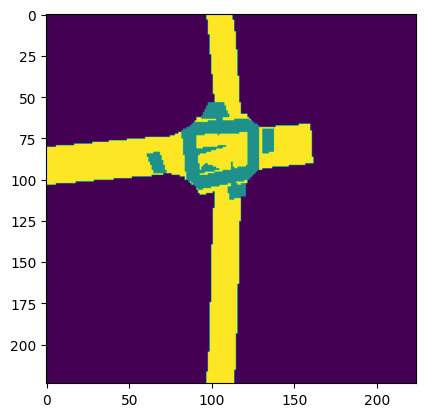

In [149]:
tmp = data[0]['raster'].roadmap_layer.numpy()

# tmp = (tmp*255).astype(np.uint8)
# for num in tmp.flatten():
#     if num not in [0, 255,127]:
#         print(num)

plt.imshow(tmp[0,:,:])

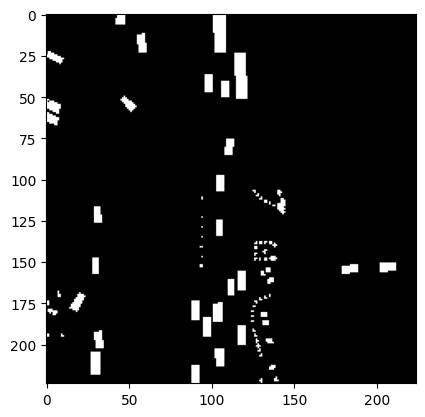

In [166]:
tmp = data[0]['raster'].agents_layer.squeeze(dim=1).numpy()
plt.imshow(tmp[1,:,:], cmap='gray')

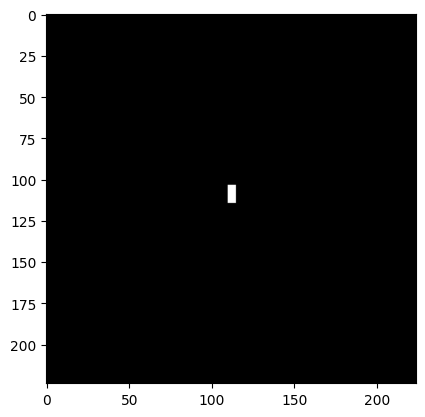

In [155]:
tmp = data[0]['raster'].ego_layer.squeeze(dim=1).numpy()
plt.imshow(tmp[0,:,:], cmap='gray')

In [52]:
xy = data[1]['trajectory'].xy[0]
print(xy)
xy = data[1]['trajectory'].xy[1]
print(xy)

tensor([[-2.2027e-04, -6.3607e-05],
        [-4.3930e-04, -1.2440e-04],
        [-6.1404e-04, -1.4012e-04],
        [-7.7451e-04, -2.2957e-04],
        [-9.0392e-04, -2.4109e-04],
        [-1.0171e-03, -2.4207e-04],
        [-1.1413e-03, -2.4756e-04],
        [-1.2345e-03, -3.1677e-04],
        [-1.3026e-03, -3.4239e-04],
        [-1.3982e-03, -3.2593e-04],
        [-1.4397e-03, -3.4425e-04],
        [-1.4165e-03, -3.1695e-04],
        [-1.4432e-03, -3.6754e-04],
        [-1.5400e-03, -4.1768e-04],
        [-1.5859e-03, -3.9425e-04],
        [-1.6377e-03, -3.7625e-04]])
tensor([[ 4.8957e+00, -9.4089e-03],
        [ 9.7460e+00,  1.1122e-02],
        [ 1.4560e+01,  3.7109e-02],
        [ 1.9374e+01,  6.2407e-02],
        [ 2.4320e+01,  9.2281e-02],
        [ 2.9424e+01,  9.7315e-02],
        [ 3.4704e+01,  1.1841e-01],
        [ 4.0009e+01,  1.6294e-01],
        [ 4.5324e+01,  2.1470e-01],
        [ 5.0682e+01,  2.6209e-01],
        [ 5.5994e+01,  3.0602e-01],
        [ 6.1283e+01,  3.52

In [230]:
data[1]['trajectory'].numpy_position_x[0, :]

array([-0.00022027, -0.0004393 , -0.00061404, -0.00077451, -0.00090392,
       -0.00101708, -0.00114127, -0.00123451, -0.00130261, -0.00139816,
       -0.00143974, -0.00141646, -0.00144319, -0.00154003, -0.00158589,
       -0.00163772], dtype=float32)

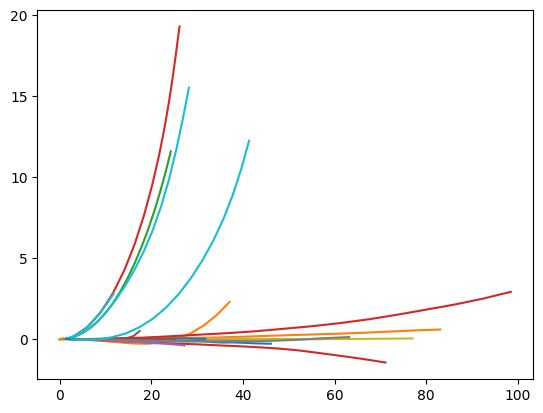

In [84]:
for i in range(len(data[1]['trajectory'].xy)):
    xy = data[1]['trajectory'].xy[i]
    x = xy[:, 0].numpy()
    y = xy[:, 1].numpy()
    # print(xy)
    plt.plot(x, y)

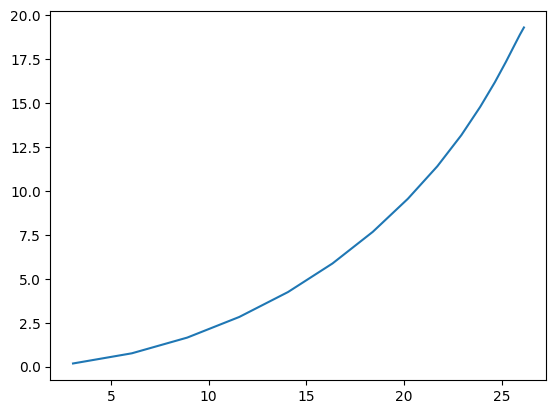

In [214]:
xy = data[1]['trajectory'].xy[3]
x = xy[:, 0].numpy()
y = xy[:, 1].numpy()
# print(xy)
plt.plot(x, y)

In [200]:
import cv2

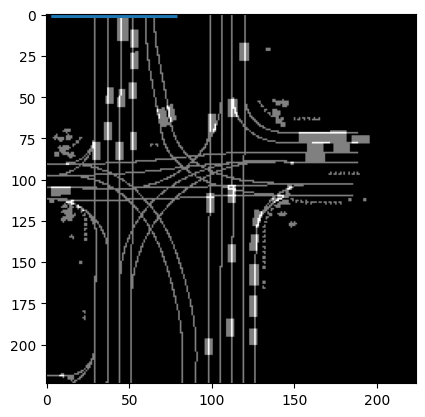

In [249]:
id = 18

tmp1 = data[0]['raster'].ego_layer.squeeze(dim=1).numpy()
tmp2 = data[0]['raster'].baseline_paths_layer.numpy()
# tmp = (tmp1.astype(int) + tmp2.astype(int)).astype(np.uint8)
tmp = cv2.add(tmp1, tmp2)
tmp3 = data[0]['raster'].agents_layer.squeeze(dim=1).numpy()
tmp = cv2.add(tmp, tmp3)
plt.imshow(tmp[id,:,:], cmap='gray')

xy = data[1]['trajectory'].xy[id]
x = xy[:, 0].numpy()
y = xy[:, 1].numpy()
# print(xy)
plt.plot(x, y, linewidth=5)